In [1]:
using Distributed
# Script for investigating amplitude dependence of potential
@everywhere using Distributions
@everywhere using Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
@everywhere using LinearAlgebra
@everywhere using LaTeXStrings
using Dates
using Primes
using MCMCDiagnostics
using SharedArrays
using DelimitedFiles
@everywhere src_path = "../Source/"
@everywhere include(src_path*"types.jl")
@everywhere include(src_path*"functions_msc.jl")
@everywhere include(src_path*"functions_neighbors.jl")
@everywhere include(src_path*"functions_types.jl")
@everywhere include(src_path*"functions_energy.jl")
@everywhere include(src_path*"functions_mc.jl")
@everywhere include(src_path*"functions_thermalization.jl")
@everywhere include(src_path*"functions_observables.jl")
@everywhere include(src_path*"functions_symmetries.jl")
@everywhere include(src_path*"jackknife_estimates.jl")
@everywhere include(src_path*"dist_lists.jl")
@everywhere include(src_path*"parallel_tempering.jl")
include(src_path*"functions_plots_and_files.jl")
using Plots
pyplot()

┌ Info: Precompiling FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1192
┌ Info: Recompiling stale cache file /home/nicolai/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/nicolai/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


Plots.PyPlotBackend()

In [2]:
using FFTW
using JLD

┌ Info: Recompiling stale cache file /home/nicolai/.julia/compiled/v1.0/JLD/l8ijy.ji for JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1190


In [3]:
cd("../Scripts/one_comp_london_T=1.5-1.8_L=32/")

In [4]:
meta_di = JLD.load("meta.jld")
f = meta_di["f"]; L₃ = meta_di["L3"]; M = meta_di["M"]; temps = meta_di["temps"]; κ₅ = meta_di["kappa"];
Δt = meta_di["dt"]; L = meta_di["L"]

32

In [5]:
N = L^2*L₃;
N_T = length(temps)

3

In [6]:
vo_di = JLD.load("vorticity.jld")

Dict{String,Any} with 3 entries:
  "sp"       => Array{Array{Float64,2},1}[[[90.3708 207.721 … 235.722 2.20138; …
  "sm"       => Array{Array{Float64,2},1}[[[76.765 223.342 … 358.309 1429.17; 4…
  "vortexes" => Tuple{Array{Float64,3},Array{Float64,3}}[([0.0370573 0.115294 ……

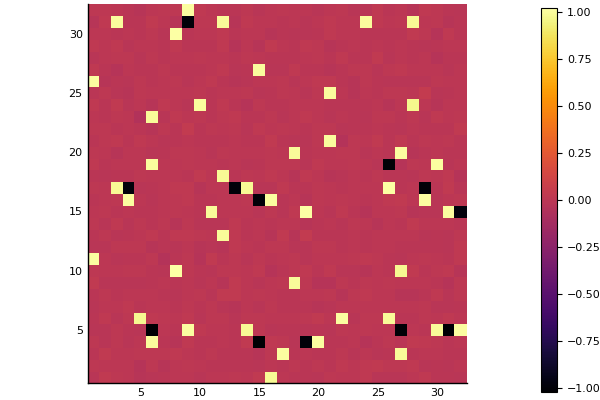

In [7]:
vortices_by_T = vo_di["vortexes"];
V⁺_by_T = [vortices_by_T[k][1] for k = 1:N_T]
heatmap(V⁺_by_T[rand(1:N_T)][:,:,rand(1:L₃)]./two_pi; aspect_ratio=1.0)

In [8]:
# Removing mid-point of L×L matrix
function removeMiddle(A::Array{T, 2}) where {T}
    L = size(A, 1)
    L_mid = floor(Int64, L/2)+1
    val = A[1,1]
    A′ = copy(A)
    A′[L_mid-1, L_mid] = val
    A′[L_mid-1, L_mid-1] = val
    A′[L_mid-1, L_mid+1] = val
    A′[L_mid-2, L_mid] = val
    A′[L_mid, L_mid] = val
    #A′[L_mid, L_mid+1] = val
    A′
end

removeMiddle (generic function with 1 method)

#### Calculating using old approach

In [89]:
# First we calculate the structure factor using the old approach
layer = 6#rand(1:L₃)
k = 1#rand(1:N_T)
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L]
S⁺_old = Array{Float64, 2}(undef, L,L); S⁻_old = Array{Float64, 2}(undef, L,L);
V⁺, V⁻ = vortices_by_T[k]
proj_V⁺ = avgVort(V⁺); proj_V⁻ = avgVort(V⁻)
for ix = 1:L, iy = 1:L
    S⁺_old[iy,ix], S⁻_old[iy,ix] = structureFunction(k_matrix[iy,ix], proj_V⁺, proj_V⁻)
end
println("Maximum: $(maximum(S⁺_old)/(L^2*f*two_pi)^2)")
# Normalization
normalization = (L^2*f*two_pi)^2
S⁺_old /= normalization; S⁻_old /= normalization;

Maximum: 1.0000000000000044


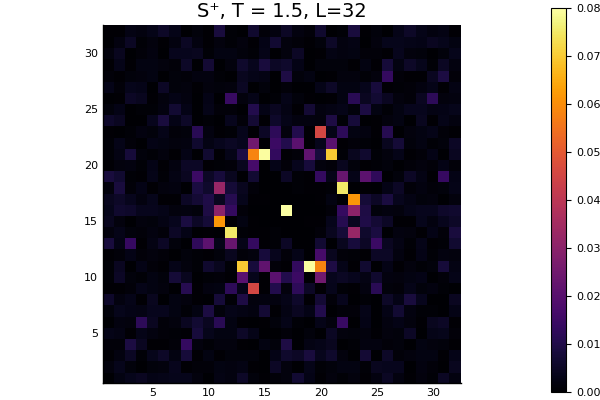

In [90]:
heatmap(S⁺_old; aspect_ratio=1.0, title="S⁺, T = $(round(reverse(temps)[k]; digits=2)), L=$(L)", clims=(0, 0.08))

#### DFFT

In [63]:
# Calculate un-normalized inverse FFT
S⁺_new_complex = bfft(proj_V⁺)
S⁺_new = abs2.(S⁺_new_complex)
println("Maximum: $(maximum(S⁺_new)/(L^2*f*two_pi)^2)")
S⁺_new /= normalization;
S⁺_re = Array{Float64, 2}(undef, L,L)
for ix = 1:L, iy = 1:L
    S⁺_re[Int(mod(iy + L/2-2, L)+1), Int(mod(ix + L/2-1, L)+1)] = S⁺_new[iy, ix]
end

Maximum: 1.0


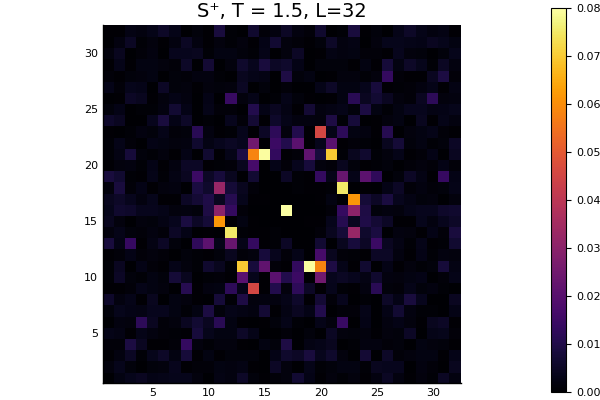

In [65]:
heatmap(S⁺_re; aspect_ratio=1.0, title="S⁺, T = $(round(reverse(temps)[k]; digits=2)), L=$(L)", clims=(0, 0.08))

In [68]:
for ix = 1:L, iy = 1:L
    @test S⁺_re[iy,ix] ≈ S⁺_old[iy,ix]
end

### Now we test the preformance of these methods

In [72]:
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L];
function sfOld(V⁺::Array{Float64, 2}, V⁻::Array{Float64, 2})
    L = size(V⁺, 1)
    S⁺_old = Array{Float64, 2}(undef, L,L); S⁻_old = Array{Float64, 2}(undef, L,L);
    for ix = 1:L, iy = 1:L
        S⁺_old[iy,ix], S⁻_old[iy,ix] = structureFunction(k_matrix[iy,ix], V⁺, V⁻)
    end
    return S⁺_old, S⁻_old
end

sfOld (generic function with 1 method)

In [78]:
function translate(V::Array{T, 2}, tr_i::Int, tr_j::Int) where {T}
    Li = size(V, 1); Lj = size(V, 2)
    V_new = Array{T, 2}(undef, Li, Lj)
    for i = 1:Li, j = 1:Lj
        V_new[Int(mod(i + tr_i - 1, Li)+1), Int(mod(j + tr_j - 1, Lj)+1)] = V[i,j]
    end
    V_new
end
function sfNew(V⁺::Array{Float64, 2}, V⁻::Array{Float64, 2})
    L = size(V⁺, 1)
    S⁺_new = abs2.(bfft(V⁺)); S⁻_new = abs2.(bfft(V⁻))
    S⁺_new = translate(S⁺_new, Int(L/2)-1, Int(L/2)); S⁻_new = translate(S⁻_new, Int(L/2)-1, Int(L/2))
    S⁺_new, S⁻_new
end

sfNew (generic function with 1 method)

In [92]:
S⁺_old, S⁻_old = sfOld(proj_V⁺, proj_V⁻);
S⁺_new, S⁻_new = sfNew(proj_V⁺, proj_V⁻);
S⁺_old /= normalization; S⁺_new /= normalization;
println(maximum(S⁺_old))
println(maximum(S⁺_new))

1.0000000000000044
1.0


In [95]:
for ix = 1:L, iy = 1:L
    @test S⁺_new[iy,ix] ≈ S⁺_old[iy,ix]
end
println(@test S⁺_new[1,1] ≈ S⁺_old[1,1])

Test Passed


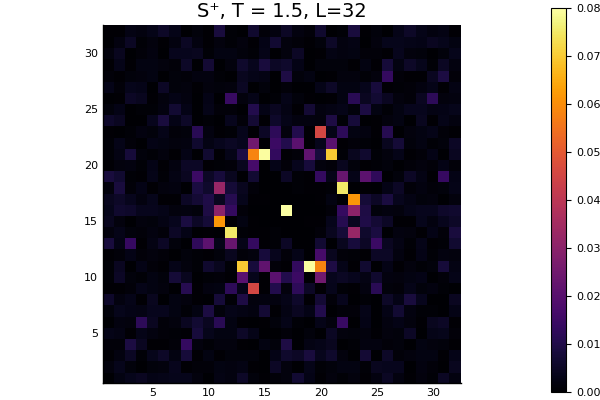

In [94]:
heatmap(S⁺_new; aspect_ratio=1.0, title="S⁺, T = $(round(reverse(temps)[k]; digits=2)), L=$(L)", clims=(0, 0.08))

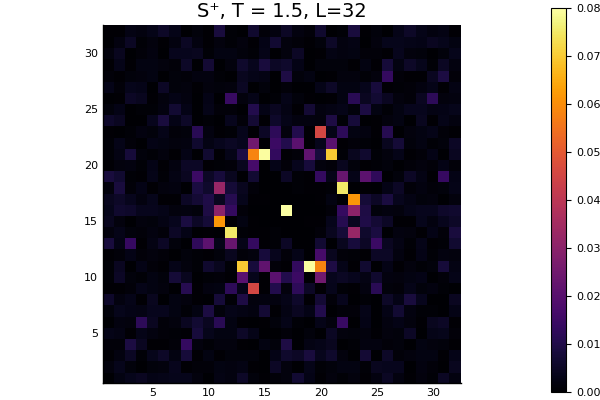

In [97]:
heatmap(S⁺_old; aspect_ratio=1.0, title="S⁺, T = $(round(reverse(temps)[k]; digits=2)), L=$(L)", clims=(0, 0.08))

### Benchmarking

In [99]:
@benchmark sfOld(proj_V⁺, proj_V⁻)

BenchmarkTools.Trial: 
  memory estimate:  96.14 MiB
  allocs estimate:  1055747
  --------------
  minimum time:     295.159 ms (16.88% GC)
  median time:      328.937 ms (15.43% GC)
  mean time:        329.588 ms (16.73% GC)
  maximum time:     341.348 ms (18.34% GC)
  --------------
  samples:          16
  evals/sample:     1

In [100]:
@benchmark sfNew(proj_V⁺, proj_V⁻)

BenchmarkTools.Trial: 
  memory estimate:  103.47 KiB
  allocs estimate:  115
  --------------
  minimum time:     164.413 μs (0.00% GC)
  median time:      237.276 μs (0.00% GC)
  mean time:        277.363 μs (11.81% GC)
  maximum time:     11.070 ms (79.96% GC)
  --------------
  samples:          10000
  evals/sample:     1

***Conclusion:*** Using the FFTW package is vastly superior when it comes to runtime and memory, and equivalent in result to the old method of calculating the structure factor.

# Test after including functionality in codebase

In [11]:
# First we calculate the structure factor using the old approach
layer = 6#rand(1:L₃)
k = 1#rand(1:N_T)
V⁺, V⁻ = vortices_by_T[k]
proj_V⁺ = avgVort(V⁺); proj_V⁻ = avgVort(V⁻)
S⁺, S⁻ = structureFunction(proj_V⁺, proj_V⁻);
normalization = (L^2*f*two_pi)^2
S⁺ /= normalization;
println(maximum(S⁺))

1.0


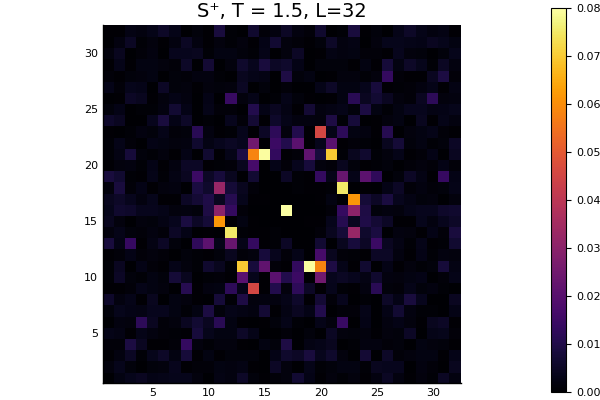

In [12]:
heatmap(S⁺; aspect_ratio=1.0, title="S⁺, T = $(round(reverse(temps)[k]; digits=2)), L=$(L)", clims=(0, 0.08))